# Milestone 3

In milestone 3 we build on the preparation in milestones 1 and 2 to prepare our data set for modeling and build an initial model that we refine in milestone 4.

### Recap: Statement of Problem

(This recap was given in milestone 2 and is presented again here for convenient reference.)

A restauranteur is planning to open a new restaurant specializing in vegan cuisine and would like to predict the success of new recipes created by the restaurant's chefs before they are served to the public. The restauranteur has hired a team of data scientists to develop a model to predict the success of new recipes based on ratings and reviews of existing recipes. The data scientists have obtained a data set from food.com (via kaggle.com) with recipes that have been rated and reviewed by the site's users. They now must determine the feasibility of developing a working model to predict the rating of a given recipe based on other attributes supplied in the data set. The initial goal is to develop a model that can predict a recipe's rating based attributes such as nutritional content, ingredients, visual characteristics, and a range of descriptive tags of recipes. A longer range goal is to perform sentiment analysis on the reviews. When the model is developed, the restaurant's chefs hope to be able to tweak the recipes they create to achieve higher ratings with the restaurant's guests and visiting food critics.

The main question: can we predict user ratings based on recipe content?

### Preparation

Import required libraries:

In [83]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import statsmodels.formula.api as sm

from scipy.optimize import curve_fit

Define global options:

In [84]:
# Display plots inline
%matplotlib inline

# Display all outputs from cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Declare functions:

In [145]:
# Plots the distribution of residuals
def plot_resid_dist(resids):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ## Plot a histogram
    sns.distplot(resids, bins=20, ax=ax[0])
    ax[0].set_title('Histogram of residuals')
    ax[0].set_xlabel('Residual values')
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of residuals')
    plt.show()

# Plots the residuals within 2 RMSE
def residual_plot(df, predicted_col, resid_col):
    RMSE = np.std(df[resid_col])
    sns.scatterplot(x=predicted_col, y=resid_col, data=df)
    plt.axhline(0.0, color='red', linewidth=1.0)
    plt.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.title('PLot of residuals vs. predicted')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()

### Data Set Description

The original source of the data set is https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions/version/2. I have prepared a new data set based on the original data set and the data cleaning steps outlined below:  https://raw.githubusercontent.com/pelorenz/vegan_recipes/master/vegan_recipes_v2.data.

### Earlier Steps to Clean the Data Set

I have extracted vegan recipes from the original data set and cleaned the data in various ways as part of my milestone project for DATASCI 400 CS as well as the present milestone project:
- Removed recipes that are not vegan based on a string-based list of tags in the kaggle.com data set
- Removed recipes that contain non-vegan ingredients that were mis-tagged as vegan in the kaggle.com data set (e.g. chicken, eggs, dairy products, etc.)
- Removed desserts, breads, and other recipes that are not main courses, sides, soups, salads, and appetizer
- Removed recipes that are incomplete for serving in a restaurant, such as spice rubs, marinades
- Removed recipes with incomplete nutritional data
- Removed recipes with an insufficient number of user reviews (less than three)
- Added missing variables that are listed on the web site but not in the data set, for example, serving size and number of servings. These variables are crucial to make use of the nutritional information for comparisons but are missing in the kaggle.com data set. I have re-added these fields to the data set by scraping food.com web side and parsing the HTML for the proper fields.
- Created dichotomous variables for categorical data parsed from string-based lists in the kaggle.com data set

### Load the Data Set

Begin by loading the data set and viewing the initial rows:

In [116]:
# Internet location of the data set
url = 'https://raw.githubusercontent.com/pelorenz/vegan_recipes/master/vegan_recipes_v2.data'

# Download the data into a dataframe object
recipes = pd.read_table(url)

# Display initial rows
recipes.head()

,name,id,n_ingredients,serving_size_g,n_servings,calories,calories_per_g,total_fat_pdv,total_fat_g,total_fat_pct,...,has_citrus,has_vinegar,has_alcohol,has_complex_sugar,is_red,is_orange,is_yellow,is_green_light,is_green_dark,is_purple
0,fool the meat eaters chili,54272,12,352,4,295.6,0.839773,3,1.95,0.005540,...,0,0,0,0,0,1,0,0,1,0
1,mock a mole low fat guacamole,81185,7,137,6,115.9,0.845985,7,4.55,0.033212,...,1,0,0,0,0,1,0,1,1,0
2,sour cream avocado dip vegan,112959,7,15,48,12.8,0.853333,1,0.65,0.043333,...,1,0,0,0,0,0,0,1,0,0
3,cream of mushroom soup,50184,9,544,4,473.2,0.869853,59,38.35,0.070496,...,0,0,0,0,0,0,0,0,0,0
4,slightly spicy black bean burgers,111462,11,223,4,337.3,1.512556,8,5.20,0.023318,...,0,0,0,0,0,0,1,0,0,0


### Building on Milestone 2 Findings

Here we examine the conclusions reached in milestone 2 and how they are relevant to building a regression model in milestone 3. In milestone 2 we set out to answer the question as to whether it is possible to predict the success of a recipe based on its contents measured in terms of user ratings. We examined the relationship between 3 variables and user ratings and identified 2 variables whose values were found to be significantly correlated with user ratings on the basis of T-tests, bootstrap resampling, Bayesian methods, ANOVA, and Tukey's HSD test. Our hypothesis tests were remarkably consistent in placing the mean user ratings of distinct groups partitioned by these features outside each other's confidence intervals.

In milestone 2 we discovered two significant relationships between features:

- low fat recipes are less likely to receive positive user ratings than either medium- or high-fat recipes
- high-sodium recipes are less likely to receive positive user ratings than low-sodium recipes

In the present milestone we can leverage this information to build our model.

### Building on Milestone 1 Findings

In milestone 1 we determined that several variables contained impossible values in which the percent in grams of a component per serving exceeded the mass in grams of the serving. The variables to which this applied were *total_fat_pct*, *sugar_pct*, and *carbohydrates_pct*. Therefore, to clean the data, we will remove any recipes that contain these impossible values on the assumption that their nutritional values are unreliable:

In [117]:
# Remove recipes for which 'total_fat_pct' contains value greater than 1.0
recipes = recipes[recipes.total_fat_pct < 1.0]

# Remove recipes for which 'sugar_pct' contains value greater than 1.0
recipes = recipes[recipes.sugar_pct < 1.0]

# Remove recipes for which 'carbohydrates_pct' contains value greater than 1.0
recipes = recipes[recipes.carbohydrates_pct < 1.0]

### Normalize Data

Normalize:

In [125]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
mean_rating = np.array(recipes['mean_rating'].values)
recipes['mean_rating_norm'] = pt.fit_transform(mean_rating.reshape(-1, 1))

### Linear Regression of User Ratings by Fat Content

Since in milestone 2 we discovered a significant relationship between fat content and user ratings, we begin with a regression model of these two variables, with fat content as the independent variable and user rating as the dependent variable.

A plot of *total_fat_pct* versus *mean_rating* reveals that the relationship between these variables is not best described by a straight line:

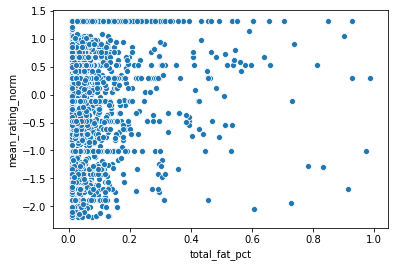

In [126]:
sns.scatterplot(x='total_fat_pct', y='mean_rating_norm', data=recipes)

Due to the ceiling of 5 on the user rating and the clustering of points along the y axis, the family of functions that appears to best describe the data is a reciprocal function of the form f(x) = p / (x - q) + r, where x is the independent variable and p, q, and r are the parameters, though in our case q = 0 and *r* = 5, the highest possible user rating.

We define a regression model, fit it to the data, and produce a labeled graph showing the best fit line with the data points:

[0.11167307 0.00226841]


C:\Users\Pete\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\Pete\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


y intercept = -inf


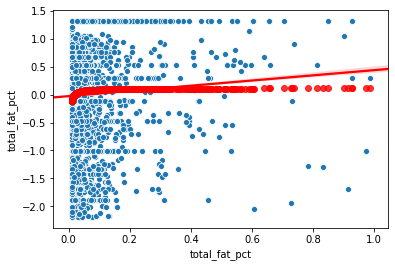

In [140]:
# Replace zeros with small number to avoid divide-by-zero problems
recipes.total_fat_pct[recipes.total_fat_pct < 0.01] = 0.01

# Curve to apply to data
def model_function(x, a, b):
    return a - b / x

# Perform least-squares regression with supplied model function
popt, pcov = curve_fit(model_function, recipes.total_fat_pct, recipes.mean_rating_norm, p0=[5, 0.4])

# Add predicted to dataframe
recipes['fat_predicted_rating'] = model_function(recipes.total_fat_pct, popt[0], popt[1])

# Print model params
print(popt)

# Plot regression
sns.scatterplot(x='total_fat_pct', y='mean_rating_norm', data=recipes)
sns.regplot(x='total_fat_pct', 
            y=model_function(recipes.total_fat_pct, popt[0], popt[1]), 
            data=recipes, color='red')

# Compute the y intercept
y_intercept = model_function(0, popt[0], popt[1])

# Display the y intercept
print('y intercept = %4.3f' % y_intercept)

The regression line curves down towards the y axis and slopes slightly upwards as fat content increases. The y intercept is negative infinity, reflecting the asymtotic nature of the function.

To assess the model we now compute the residuals, R-squared, and adjusted R-squared:

In [121]:
# Compute residuals and add to dataframe
recipes['fat_residuals'] = recipes.mean_rating_norm - model_function(recipes.total_fat_pct,
                                                                     popt[0], popt[1])

# Compute total and residual sums of squares
ss_res = np.sum(recipes['fat_residuals'] ** 2)
ss_tot = np.sum((recipes.mean_rating_norm - np.mean(recipes.mean_rating_norm)) ** 2)

# Compute R squared
r_squared = 1 - (ss_res / ss_tot)

# Number of samples
n, _ = recipes.shape

# Number of independent variables
p = 1

# Compute adjusted R squared
adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Display R-squared and adjusted R-squared
print('R-squared = %4.4f Adjusted R-squared = %4.4f' % (r_squared, adj_r_squared))

R-squared = 0.0072 Adjusted R-squared = 0.0069


The low values of R-squared and adjusted R-squared suggests that the model is not able to account for variability in the data set.

We now compute the root mean-squared error, which is analogous to the standard deviation of the unexplained variance:

In [122]:
# Print mean of residuals
print('The mean of the residuals = %4.3f' % (np.mean(recipes.fat_residuals)))

# Print RMSE
RMSE = np.std(recipes.fat_residuals)
print('RMSE = %4.3f' % (RMSE))

The mean of the residuals = 0.000
RMSE = 0.996


The root mean-squared error is within one standard deviation, suggesting that most observations do not lie far beyond the regression curve.

We plot the residuals to determine their distribution:

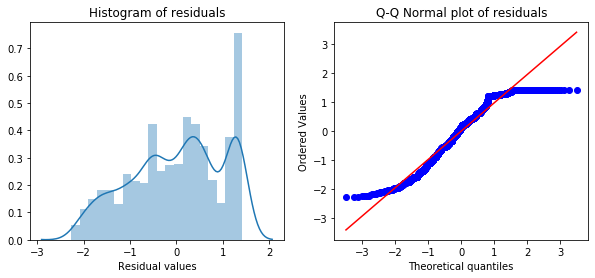

In [123]:
# Plot distribution of the residuals
plot_resid_dist(recipes.fat_residuals)

The residuals are not normally distributed as we would expect if the regression curve fit the data.

We now test how much the residuals fall within 2 RMSE's and how evenly they do so:

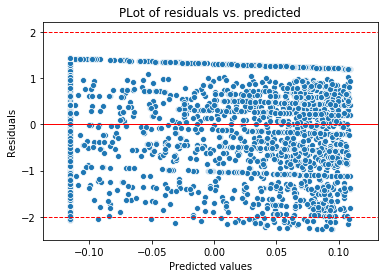

In [124]:
# Plot the residuals within 2 RMSE    
residual_plot(recipes, 'fat_predicted_rating', 'fat_residuals')  

The residuals have a boxy shape that is not evenly distributed withing 2 RMSE's of the regression curve, suggesting that the model has serious problems. Analysis of the residuals and their distribution suggests that the model is no better than choosing the mean as the predictor.

### Linear Regression of User Ratings by Sodium Content

Similarly, in milestone 2 we discovered a significant relationship between sodium content and user ratings. So we next build a regression model of these two variables, with sodium content as the independent variable and user rating as the dependent variable.

A plot of *sodium_pct* versus *mean_rating* reveals that the relationship between these variables is not best described by a straight line:

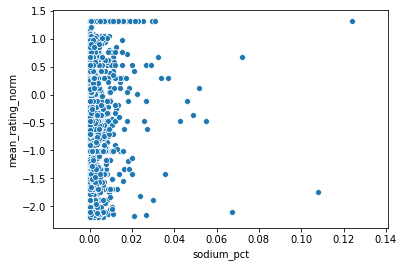

In [128]:
sns.scatterplot(x='sodium_pct', y='mean_rating_norm', data=recipes)

Again, due to the ceiling of 5 on the user rating and the clustering of points along the y axis, the family of functions that appears to best describe the data is a reciprocal function of the form f(x) = p / (x - q) + r, where (once again) x is the independent variable and p, q, and r are the parameters, though in our case q = 0 and r = 5, the highest possible user rating.

We define a regression model, fit it to the data, and produce a labeled graph showing the best fit line with the data points:

[-0.10917525 -0.00015671]


C:\Users\Pete\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\Pete\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


y intercept =  inf


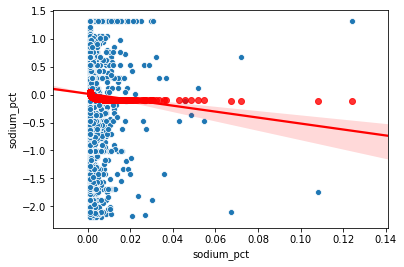

In [139]:
# Replace zeros with small number to avoid divide-by-zero problems
recipes.sodium_pct[recipes.sodium_pct < 0.001] = 0.001

# Curve to apply to data
def model_function(x, a, b):
    return a - b / x

# Perform least-squares regression with supplied model function
popt, pcov = curve_fit(model_function, recipes.sodium_pct, recipes.mean_rating_norm, p0=[5, 0.4])

# Add predicted to dataframe
recipes['sodium_predicted_rating'] = model_function(recipes.sodium_pct, popt[0], popt[1])

# Print model params
print(popt)

# Plot regression
sns.scatterplot(x='sodium_pct', y='mean_rating_norm', data=recipes)
sns.regplot(x='sodium_pct', 
            y=model_function(recipes.sodium_pct, popt[0], popt[1]), 
            data=recipes, color='red')

# Compute the y intercept
y_intercept = model_function(0, popt[0], popt[1])

# Display the y intercept
print('y intercept = %4.3f' % y_intercept)

The regression line curves down from the y axis and slopes slightly downwards as sodium content increases. The y intercept is positive infinity, reflecting the asymtotic nature of the function.

To assess the model we now compute the residuals, R-squared, and adjusted R-squared:

In [141]:
# Compute residuals and add to dataframe
recipes['sodium_residuals'] = recipes.mean_rating_norm - model_function(recipes.sodium_pct,
                                                                        popt[0], popt[1])

# Compute total and residual sums of squares
ss_res = np.sum(recipes['sodium_residuals'] ** 2)
ss_tot = np.sum((recipes.mean_rating_norm - np.mean(recipes.mean_rating_norm)) ** 2)

# Compute R squared
r_squared = 1 - (ss_res / ss_tot)

# Number of samples
n, _ = recipes.shape

# Number of independent variables
p = 1

# Compute adjusted R squared
adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Display R-squared and adjusted R-squared
print('R-squared = %4.4f Adjusted R-squared = %4.4f' % (r_squared, adj_r_squared))

R-squared = -2.8328 Adjusted R-squared = -2.8341


The high values of R-squared and adjusted R-squared suggest that the model is not a good fit for the data.

We now compute the root mean-squared error, which is analogous to the standard deviation of the unexplained variance:

In [143]:
# Print mean of residuals
print('The mean of the residuals = %4.3f' % (np.mean(recipes.sodium_residuals)))

# Print RMSE
RMSE = np.std(recipes.sodium_residuals)
print('RMSE = %4.3f' % (RMSE))

The mean of the residuals = 1.469
RMSE = 1.294


The root mean-squared error is slightly beyond one standard deviation, suggesting that most observations do not lie far beyond the regression curve.

We plot the residuals to determine their distribution:

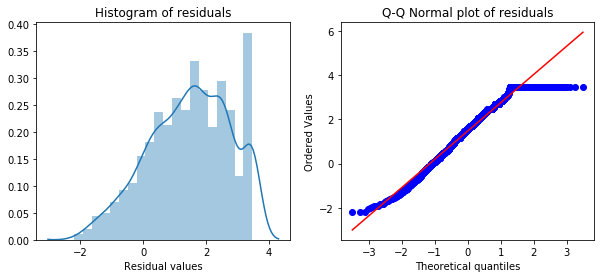

In [144]:
# Plot distribution of the residuals
plot_resid_dist(recipes.sodium_residuals)

The residuals are not normally distributed as we would expect if the regression curve fit the data.

We now test how much the residuals fall within 2 RMSE's and how evenly they do so:

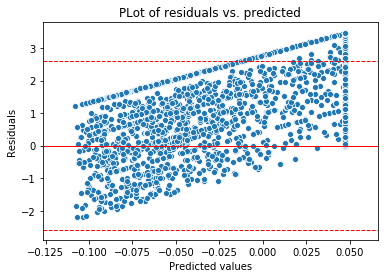

In [146]:
# Plot the residuals within 2 RMSE    
residual_plot(recipes, 'sodium_predicted_rating', 'sodium_residuals')  

The residuals are sloped upwards as the predicted values increase suggesting that there are other factors at play in the model which are unrelated to the independent variable and, hence, that the model has serious problems.